In [3]:
import scipy.io
import os
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from pathlib import Path
from collections import namedtuple
import random
import numpy.ma as ma
import scipy.signal as ssignal

In [2]:
### Thresholds for ethogram buildin
LIKELIHOOD_LIM = 0.9
def center_model(position, likelihood_threshold = 0.5):
    
    center_position_model = np.zeros((2,))
    count = 0
    sum_x = 0
    sum_y = 0
    for i in range(8):
        if position[i,2] > likelihood_threshold:
            sum_x += position[i,0]
            sum_y += position[i,1]
            count+=1
    center_position_model[0] = sum_x / count
    center_position_model[1] = sum_y / count
    
    return center_position_model

def radius_model(position, center_position, likelihood_threshold, model_id):
    
    count = 0
    sum_rad = 0
    
    for i in range(8):
        if position[i,2] > likelihood_threshold:
            sum_rad += np.sqrt((position[i,0]-center_position[0])**2 + (position[i,1]-center_position[1])**2)
            count+=1

    return sum_rad / count

def shape_model(position, likelihood_threshold,model_id):
    
    '''
    Create a model circular model for pupil.
    
    input -> tracking: numpy array, contains positions along the eye. 
    Here we use the convetion for labeling: PupilCenter,PupilN,PupilE,PupilS,PupilW,PupilNE,PupilSE,PupilSW,PupilNW.
    
    output -> shape : tupple, that contains the model for radius and center
    
    '''
    #center_value
    center_data = np.zeros((2,))
    center_m = center_model(position[1:,:],likelihood_threshold)

    if position[0,2] > likelihood_threshold:
        center_data[0] = position[0,0]
        center_data[1] = position[0,1]
    else:
        center_data = center_m
        
    
    radius_1 = radius_model(position[1:,:], center_data, likelihood_threshold,model_id)
    radius_2 = radius_model(position[1:,:], center_m, likelihood_threshold,model_id)

    shape = namedtuple('shape', ['center','center_model','radius'])
    
    return shape(center_data , center_m, radius_1)

def pupil_model(tracking = None, model_id = 0, likelihood_threshold = 0.8):
    
    '''
    Create a circular model for pupil shape, dilatation. 
    Different version refer to the data that will be use to create the model.
    
    
    input -> tracking : tracking of a 9 positions of the eye
             model_id: version of model to create the pupil:
             0 : mean over radius positions from center
             1 : mean over diameter positions
             
    
    output -> pupil_model: model of the mouse movement in time, that conteins center position and radius.
            center position is recomputed by using the tracking of the 8 points sorrounding the pupil
    
    '''
    model = [shape_model(tracking[:,i,:],model_id,likelihood_threshold) for i in range(tracking.shape[1])]
        
    pupil_model = namedtuple('pupil_model', ['shape_model'])
       
    return pupil_model(model)


### Createa video with the model
NTIME = 5000
def create_pupil_dilatation_video(input_video_file, output_video_file,model1):
    
    cap = cv2.VideoCapture(str(input_video_name))
    #cap.set(cv2.CAP_PROP_POS_FRAMES, )
    w = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    h = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    #fourcc = cv.VideoWriter_fourcc('m', 'p', '4', 'v')
    #writer = cv.VideoWriter(file_path, fourcc, fps, (w, h))
    output = cv2.VideoWriter(str(output_video),cv2.VideoWriter_fourcc(*'MJPG'),20,(w,h))

    center = [model1.shape_model[frame_n].center.astype(int) for frame_n in range(len(model1.shape_model))]

    offset = length - len(center)

    for frame_n in range(length-offset):

        r , frame = cap.read()    
        if frame_n > offset:
            center1 = model1.shape_model[frame_n-offset].center.astype(int)
            radius1 = model1.shape_model[frame_n-offset].radius.astype(int) 
            cv2.circle(frame, tuple(center1),radius1, color = (255,0,0), thickness = 2)
    

        output.write(frame)
    
    return

In [11]:
## load tracking information
tracking_path = Path(r'C:\Users\Barbara\Documents\Radboud uni\Internship\Deeplabcut\Model 2')

tracking_path.exists()
input_file_name = '0-used for model- 2021-Dec-13_21-08-09_picamera_DLC_resnet50_Pupil_size_Test_Varvara_2jul4shuffle1_800000.csv'

tracking_DFrame = pd.read_csv(tracking_path / input_file_name, low_memory = False)

tracking_path =r'C:\Users\Barbara\Documents\Radboud uni\Internship\Deeplabcut\Model 2'
input_video_name = tracking_path + r'C:\Users\Barbara\Documents\Radboud uni\Internship\Deeplabcut\Model 2'
output_video = tracking_path + 'tracking_example.mp4'

figures_path = r'C:\Users\Barbara\Documents\Radboud uni\Internship\Deeplabcut\Model 2\Figures'


In [7]:
## get body parts from tracking fil
eye_parts = [tracking_DFrame.iloc[0][i*3+1] for i in range(int(len(tracking_DFrame.iloc[0])/3))]
eye_part_structure = [tracking_DFrame.iloc[1][i+1] for i in range(3)]

print(eye_parts)
print(eye_part_structure)
tracking_DFrame = tracking_DFrame.iloc[0:]

['EyeN', 'EyeS', 'EyeW', 'EyeE', 'PupilCenter', 'PupilN', 'PupilE', 'PupilS', 'PupilW', 'PupilNE', 'PupilSE', 'PupilSW', 'PupilNW']
['x', 'y', 'likelihood']


In [8]:
# convert tracking pandas to numpy
tracking_DFrame = tracking_DFrame.iloc[2:]
tracking_DFrame = tracking_DFrame.astype(float)
tracking_data = tracking_DFrame.to_numpy()
print(tracking_data.shape)

(65129, 40)


In [9]:
eye_tracking = tracking_data[:,1+4*3:];
print(eye_tracking.shape)
tracking = np.array([eye_tracking[:,[i*3,i*3+1,i*3+2]] for i in range(9)])
print(tracking.shape)

(65129, 27)
(9, 65129, 3)


In [12]:
pupil_model_radius = pupil_model(tracking)
print(input_video_name)
print(output_video)
#create_pupil_dilatation_video(input_video_name, output_video,pupil_model_radius)

C:\Users\Barbara\Documents\Radboud uni\Internship\Deeplabcut\Model 2C:\Users\Barbara\Documents\Radboud uni\Internship\Deeplabcut\Model 2
C:\Users\Barbara\Documents\Radboud uni\Internship\Deeplabcut\Model 2tracking_example.mp4


In [13]:
center1 = [pupil_model_radius.shape_model[frame_n].center for frame_n in range(len(pupil_model_radius.shape_model))]
radius = [pupil_model_radius.shape_model[frame_n].radius for frame_n in range(len(pupil_model_radius.shape_model))]

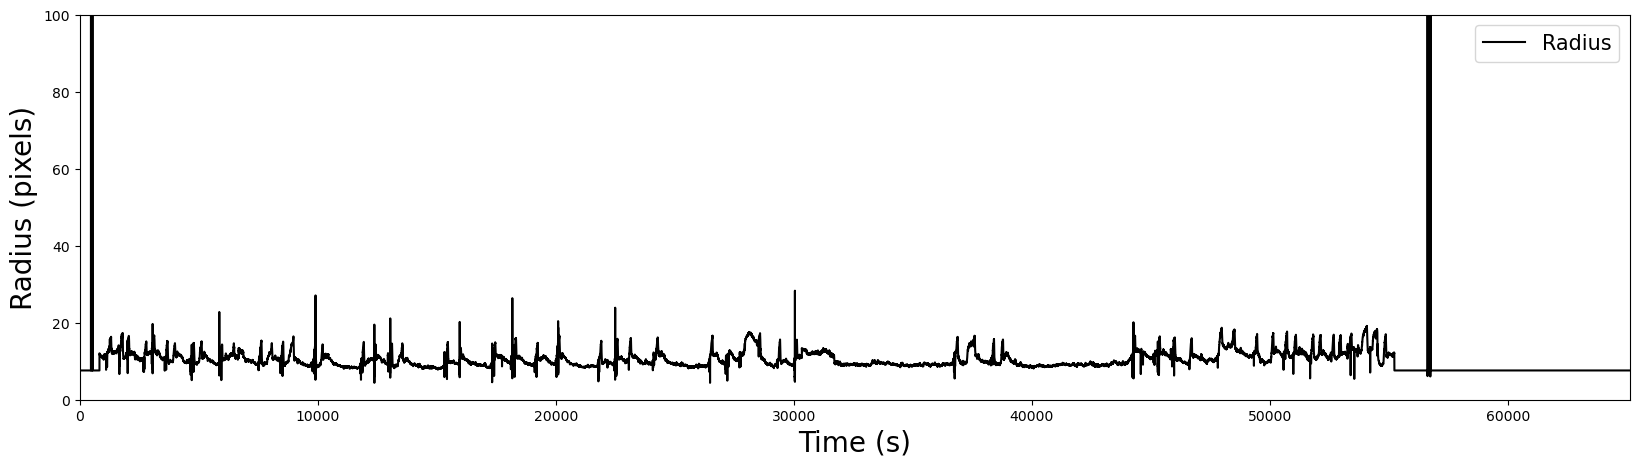

In [14]:
figure, axes = plt.subplots()
time = np.arange(0,len(radius))
smothed_radius = ssignal.medfilt(radius,9)

axes.plot(time,radius, c = 'k')
#axes.plot(time,smothed_radius,c = 'b')

axes.set_xlim([0,len(radius)])
axes.set_ylim([0,100])

axes.set_xlabel('Time (s)', fontsize = 20)
axes.set_ylabel('Radius (pixels)', fontsize = 20)

axes.legend(['Radius','Filtered Radius'],fontsize = 15)
figure.set_size_inches([20,5])


To create NPY files of radius

In [27]:
# Set the directory containing the CSV files

dir_path ='C:/Users/Barbara/Documents/Radboud uni/Internship/Deeplabcut/Model 2/'

# Get a list of all CSV files in the directory
csv_files = sorted([f for f in os.listdir(dir_path) if f.endswith(".csv")])
(csv_files)

['0-used for model- 2021-Dec-13_21-08-09_picamera_DLC_resnet50_Pupil_size_Test_Varvara_2jul4shuffle1_800000.csv',
 '1- 2021-Dec-12_18-50-53_picamera_DLC_resnet50_Pupil_size_Test_Varvara_2jul4shuffle1_800000.csv',
 '2- 2021-Dec-12_21-17-32_picamera(weird view)_DLC_resnet50_Pupil_size_Test_Varvara_2jul4shuffle1_800000.csv',
 '3- 2021-Dec-12_20-35-47_picamera_DLC_resnet50_Pupil_size_Test_Varvara_2jul4shuffle1_800000.csv']

In [33]:
output_path = 'C:/Users/Barbara/Documents/Radboud uni/Internship/Deeplabcut/Model 2/Output/'
tracking_path = Path(dir_path)

for i in range(len(csv_files)):
    tracking_DFrame = pd.read_csv(tracking_path / csv_files[i])
    ## get body parts from tracking fil
    eye_parts = [tracking_DFrame.iloc[0][i*3+1] for i in range(int(len(tracking_DFrame.iloc[0])/3))]
    eye_part_structure = [tracking_DFrame.iloc[1][i+1] for i in range(3)]
    
    print(eye_part_structure)
    tracking_DFrame = tracking_DFrame.iloc[0:]
    # convert tracking pandas to numpy
    tracking_DFrame = tracking_DFrame.iloc[2:]
    tracking_DFrame = tracking_DFrame.astype(float)
    tracking_data = tracking_DFrame.to_numpy()
    print(tracking_data.shape)
    eye_tracking = tracking_data[:,1+4*3:];
    tracking = np.array([eye_tracking[:,[i*3,i*3+1,i*3+2]] for i in range(9)])
    print(tracking.shape)
    pupil_model_radius = pupil_model(tracking)
    center1 = np.array([pupil_model_radius.shape_model[frame_n].center for frame_n in range(len(pupil_model_radius.shape_model))])
    radius = np.array([pupil_model_radius.shape_model[frame_n].radius for frame_n in range(len(pupil_model_radius.shape_model))])
    
    radius_name = output_path + csv_files[i][0:50] + '_radius.npy'
    #center_name = output_path + input_file_name_list[i][0:50] + '_center.npy'
    
    np.save(radius_name,radius)
    #np.save(center_name,center1)

C:\Users\Barbara\AppData\Local\Temp\ipykernel_11364\1963640134.py:5: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39) have mixed types. Specify dtype option on import or set low_memory=False.
  tracking_DFrame = pd.read_csv(tracking_path / csv_files[i])


['x', 'y', 'likelihood']
(65129, 40)
(9, 65129, 3)


C:\Users\Barbara\AppData\Local\Temp\ipykernel_11364\1963640134.py:5: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39) have mixed types. Specify dtype option on import or set low_memory=False.
  tracking_DFrame = pd.read_csv(tracking_path / csv_files[i])


['x', 'y', 'likelihood']
(76375, 40)
(9, 76375, 3)


C:\Users\Barbara\AppData\Local\Temp\ipykernel_11364\1963640134.py:5: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39) have mixed types. Specify dtype option on import or set low_memory=False.
  tracking_DFrame = pd.read_csv(tracking_path / csv_files[i])


['x', 'y', 'likelihood']
(30236, 40)
(9, 30236, 3)


C:\Users\Barbara\AppData\Local\Temp\ipykernel_11364\1963640134.py:5: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39) have mixed types. Specify dtype option on import or set low_memory=False.
  tracking_DFrame = pd.read_csv(tracking_path / csv_files[i])


['x', 'y', 'likelihood']
(39711, 40)
(9, 39711, 3)
